# Supplementary Source Code 5 – Wheat Growth Patterns and Predictive Modelling 

This Jupyter notebook describes how we utilise fast Fourier transform algorithm (FFT) to separate the frequencies (x-axis, cycles per day) for presenting the frequency of growth and the magnitude spectrum (y-axis, normalised amplitudes) for presenting the degree of growth. By doing so, we have extracted underlying dynamic growth patterns of Paragon wheat NILs as well as other crop species. 

For the GxE growth prediction model, its lightweight nature allows it to be run on a single-board computer such as a Pi computer to give growth-related quantifications and then the prediction can be correlated with real measurements produced by the CQ platform. With larger crop-climate datasets containing more biological replicates and cross-validation testing, the model is gradually being improved with new annual results. A special function embedded in the GxE model is that it can trigger warning messages the CQ platform, if the crop growth rate has deviated from the bounds of its estimated growth region (±1SD). 

The algorithms are based on Crop-Climate datasets generated by the CropQuant platform and the automated trait analysis pipeline SC4-CropTraitMeasuring_PC_V1.15 running on a PC or a HPC cluster. Based on the Jupyter server, we provide an interactive environment to facilitate a range of modelling and machine learning libraries imports, our tailored and modulated functions to carry out feature extraction, FFT and underlying growth patterns, growth peaks identification, and estimate/real measurements correlation. 

## Please note that:   
* A Jupyter notebook is ONLY used for demonstrating the algorithm, NOT for batch processing big crop image series.
* The performance of the algorithm provided for the CropQuant breeding project could be varied due to an end-user's computing resources such as physical memory and CPU speed.
* Users might encounter issues with specific libraries if they have not installed properly or not been optimised for Linux-based operating systems.
* We recommend users to preinstall the latest open Anaconda Python distribution before using functions and modules in the CropQuant analysis pipeline that requires Scikit-image or Scikit-learning functions. 


In [3]:
#################################################################
#                                                               #
#    Authors: Mr Tom Le-Cornu, Thomas.Le-Cornu@earlham.ac.uk    #
#             Dr Ji Zhou (周济), ji.zhou@earlham.ac.uk           #
#    Date: 27th October 2016                                    #
#                                                               #
#    Version: 0.1 on EI internal Github                         #
#    Stable version: 1.15 on EI internal Github and Bitbcuket   #
#                                                               #
#    Software license: the bespoke CropQuant Software License   # 
#    the algorithm below is developed by Dr Zhou and his lab,   #
#    which shall only be used for research purpose.             #
#                                                               #
#################################################################

%matplotlib inline
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid", font_scale=1.5)
from scipy.stats import pearsonr
from itertools import chain
from scipy.signal import medfilt
from matplotlib.colors import ColorConverter
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import scipy.io as sio

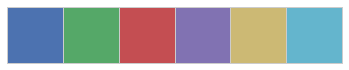

In [4]:
blue, green, red = sns.color_palette()[:3]
sns.palplot(sns.color_palette())

## Calculate RGR and normalise height readings

In [5]:
def get_rgr(a, N):
    """ Return the relative growth rate of an N day lag as a set of per cent values. """
    return (a[N:] - a[:-N]) / a[:-N]

In [6]:
def rolling_window(a, window, pad=False):
    """ Extract windows with specified length from a. Padding ensures the first-dimensions
    of input and output arrays are the same.
    """
    if pad:
        wn_2 = int(math.floor(window / 2))
        a = np.pad(a, wn_2, 'edge')
        
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# a = np.arange(10)
# print a.shape
# print rolling_window(a, 3, pad=True).mean(1).shape

In [7]:
# Predicted growth stage data - using SVM models from Supplementary Source Code 6 – Growth Stage Prediction
#pred_gs_2015 = sio.loadmat("PredGS_2015.mat")['p_gs'].ravel()
#pred_gs_2016 = sio.loadmat("PredGS_2016.mat")['p_gs'].ravel()


In [16]:
df = df_2015 = pd.read_csv("CropEnv_Ref_2015_Data.csv")
df.head()

,ID,Real_Height,Nom_DegDay_May,Acc_DegDay,ThermU_Day,Avg_Temp,SolarRadi_Day,Light_Dur_Day,AVG_LightInt_Day,Rain,Wind,RGR,GS_Days,Genotype,Grow_Stg
0,0,20.6,51,1269,9.7,10.9,7.5,14.8,95.63,3.0,19,NAN,-25,G1,1
1,1,20.6,51,1269,9.7,10.9,7.5,14.8,95.63,3.0,19,0%,-24,G1,1
2,2,23.2,63,1280,11.4,10.5,6.1,15.4,83.16,3.3,15,12.62%,-23,G1,1
3,3,21.5,69,1286,6.1,13.3,3.6,15.6,84.54,0.0,32,-7.33%,-22,G1,1
4,4,24.4,86,1303,16.9,10.8,9.2,15.4,89.83,0.0,18,13.49%,-21,G1,1


In [17]:
genotypes = ['G1', 'G2', 'G3', 'G4', 'G5', 'GT']
stages = [1, 2, 3, 4, 5, 6]
genotypes, stages

(['G1', 'G2', 'G3', 'G4', 'G5', 'GT'], [1, 2, 3, 4, 5, 6])

G1: 95 days
G2: 95 days
G3: 95 days
G4: 95 days
G5: 95 days
GT: 95 days


(0, 94)

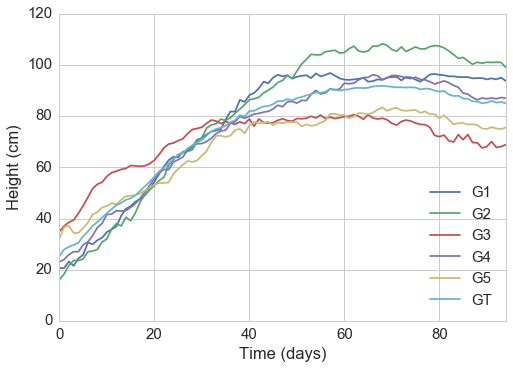

In [18]:
for geno in genotypes:
    geno_mask = df['Genotype'] == geno
    y = df['Real_Height'][geno_mask].as_matrix()
    print "{}: {} days".format(geno, y.size)
    plt.plot(y, label=geno)

plt.legend(loc="lower right")
plt.xlabel("Time (days)")
plt.ylabel("Height (cm)")
plt.xlim([0, 94])

In [19]:
def to_one_hot(x):
    """ Convert an index value to a one hot encoding. """
    A = np.zeros((x.size, 6))
    A[np.arange(x.size), x - 1] = 1
    return A

# print to_one_hot(np.array([1, 2, 3, 6, 5, 4]))

In [20]:
def to_stage_days(x):
    """ Produce a vector of increasing values for each growth stage. """
    return np.concatenate([np.arange((x == i).sum()) for i in np.unique(x)])

In [21]:
def get_height_from_pred(start, rgr_pred):
    """ Return the height growth of a plant given a start height and vector of RGRs. """
    geno_pred_rh = [start]
    for per in rgr_pred:
        prev_height = geno_pred_rh[-1]
        new_height = prev_height * (1. + per)
        geno_pred_rh.append(new_height)
    return np.array(geno_pred_rh)

In [22]:
df_2016 = pd.read_csv("CropEnv_Ref_2016_Data.csv")
df_2016.head()

,Date,Day_ID,Height,Nom_DegDay,Accu_DegDay,Avg_Temp,SolarRadi_Day,Light_Dur_Day,Rainfall,Wind,RGR,Genotype,Grow_Stg,GS_Days
0,18/04/2016,1,27.3,8.2,1249.7,8.5,47.9,14.5,0.0,6.0,1.64%,G1,1,-30
1,19/04/2016,2,28.7,7.8,1257.9,8.8,89.3,15.0,0.0,4.4,4.73%,G1,1,-29
2,20/04/2016,3,29.2,5.8,1265.7,6.5,104.6,15.0,0.0,3.5,1.70%,G1,1,-28
3,21/04/2016,4,29.5,7.9,1271.5,8.6,88.4,15.0,0.0,4.4,0.87%,G1,1,-27
4,22/04/2016,5,30.7,7.9,1279.4,8.0,43.7,15.0,1.0,5.0,4.02%,G1,1,-26


In [23]:
# Set the GT as the wild type
df_2015 = pd.read_csv("CropEnv_Ref_2015_Data.csv")
geno_mask = df['Genotype'] == 'GT'

## Examine performance-related features

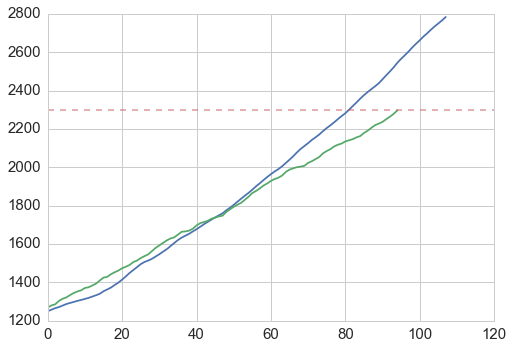

In [24]:
plt.plot(df_2016['Accu_DegDay'])
plt.plot(df_2015['Acc_DegDay'][geno_mask].as_matrix())

plt.plot([0, 120], [2300, 2300], '--', alpha=0.5)

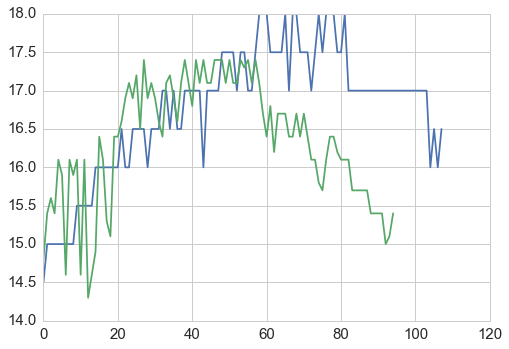

In [25]:
plt.plot(df_2016['Light_Dur_Day'])
plt.plot(df_2015['Light_Dur_Day'][geno_mask].as_matrix())

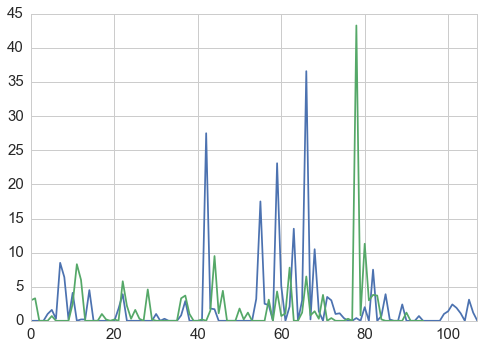

In [26]:
df_2016['Rainfall'].plot()
plt.plot(df_2015['Rain'][geno_mask].as_matrix())

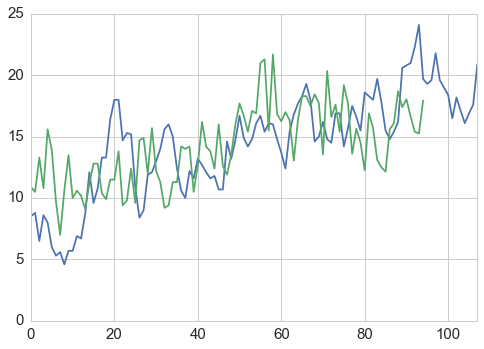

In [27]:
df_2016['Avg_Temp'].plot()
plt.plot(df_2015['Avg_Temp'][geno_mask].as_matrix())

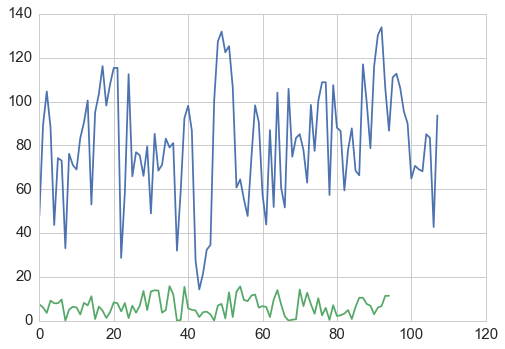

In [28]:
srd_16 = df_2016['SolarRadi_Day'].as_matrix()
srd_15 = df_2015['SolarRadi_Day'][geno_mask].as_matrix()

plt.plot(srd_16)
plt.plot(srd_15)

In [29]:
rms = lambda a: np.sqrt(np.mean(np.power(a, 2)))
rms(srd_15), rms(srd_16)

(7.8236079979292903, 85.00401352180269)

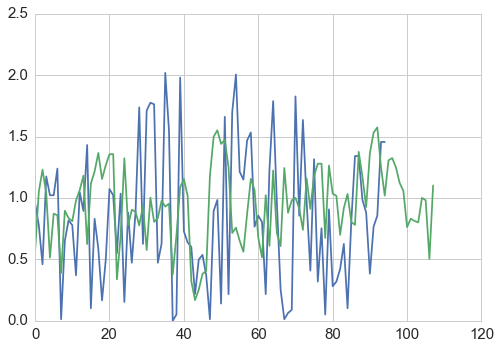

In [30]:
plt.plot(srd_15 / rms(srd_15))
plt.plot(srd_16 / rms(srd_16))

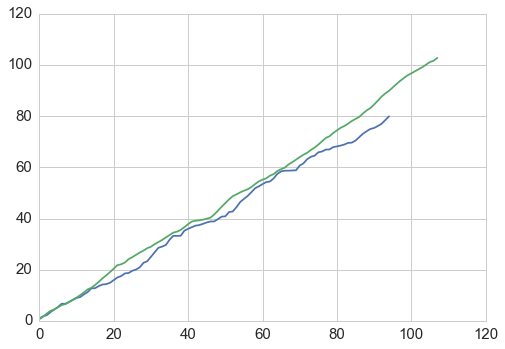

In [31]:
# Reshape the plot
plt.plot(np.cumsum(srd_15 / rms(srd_15)))
plt.plot(np.cumsum(srd_16 / rms(srd_16)))

In [99]:
# Accumulated Degree Day readings
pred_gs_2016 = pred_gs_2016[np.where(df_2016['Accu_DegDay'] <= 2300.)[0]][1:]

df_2016 = df_2016[df_2016['Accu_DegDay'] <= 2300.]
y_2016 = df_2016['Height'].as_matrix()

print y_2016.shape, pred_gs_2016.shape

(81L,) (80L,)


## Gather organised data and train models

In [100]:
srd_16 = df_2016['SolarRadi_Day'].as_matrix()
srd_15 = df_2015['SolarRadi_Day'][geno_mask].as_matrix()

X_2015 = np.vstack([
    df_2015['Acc_DegDay'][geno_mask].as_matrix(),
    df_2015['Light_Dur_Day'][geno_mask].as_matrix(),
    rolling_window(df_2015['Rain'][geno_mask].as_matrix(), 3, pad=True).sum(1).cumsum(),
    rolling_window(df_2015['Avg_Temp'][geno_mask].as_matrix(), 3, pad=True).mean(1),
    rolling_window(srd_15 / rms(srd_15), 3, pad=True).sum(1).cumsum(), # Solar radiation day
]).T

X_2016 = np.vstack([
    df_2016['Accu_DegDay'].as_matrix(),
    df_2016['Light_Dur_Day'].as_matrix(),
    rolling_window(df_2016['Rainfall'].as_matrix(), 3, pad=True).sum(1).cumsum(),
    rolling_window(df_2016['Avg_Temp'].as_matrix(), 3, pad=True).mean(1),
    rolling_window(srd_16 / rms(srd_16), 3, pad=True).sum(1).cumsum(), # Solar radiation day
]).T

# Remove first row as this corresponds to the nan of the first values from the RGRs of the height
X_2015 = X_2015[1:]
X_2016 = X_2016[1:]
X_2015.shape, X_2016.shape

((94L, 5L), (80L, 5L))

In [101]:
# Pad 2016 data as it covers less time than 2015
all_ys = [np.concatenate([y_2016, np.ones(14) * np.nan])] 
for idx, geno in enumerate(genotypes):
    
    if geno == 'GT':
        continue
    
    geno_mask = df['Genotype'] == geno
    y = df['Real_Height'][geno_mask].as_matrix()
    all_ys.append(y)
    
all_ys = np.vstack(all_ys).T
print all_ys.shape
rh_std = np.nanstd(all_ys - all_ys[0], 1).mean()
print rh_std

(95L, 6L)
11.8191149304


In [102]:
# Relative growth for both 2015 and 2016
rgr_2016 = get_rgr(df_2016['Height'].as_matrix(), 1)
print rgr_2016.shape

rgrs_2015 = {}

for geno in genotypes[:-1]:

    print geno
    geno_mask = df_2015['Genotype'] == geno
    y = df['Real_Height'][geno_mask].as_matrix()
    
    rgrs_2015[geno] = get_rgr(y, 1)
    print rgrs_2015[geno].shape

(80L,)
G1
(94L,)
G2
(94L,)
G3
(94L,)
G4
(94L,)
G5
(94L,)


In [103]:
na_to_drop = [0, 25, 64, 69, 97, 120]

In [104]:
# Incorporate growth stage prediction 
stage_data = {}
for st in stages:    
    st_X = []
    st_y = []
    st_2016_mask = (df_2016['Grow_Stg'] == st).as_matrix()[1:]

    this_X = X_2016[st_2016_mask]
    this_X = np.hstack([this_X, np.arange(this_X.shape[0]).reshape(-1, 1)]) 
    st_X.append(this_X)
    st_y.append(rgr_2016[st_2016_mask])

    # Assign for each Genotype for each growth stage
    for geno in genotypes[:-1]:      
        geno_mask = df_2015['Genotype'] == geno
        geno_stg_mask = (df_2015['Grow_Stg'][geno_mask] == st).as_matrix()[1:]
        
        this_X = X_2015[geno_stg_mask]
        this_X = np.hstack([this_X, np.arange(this_X.shape[0]).reshape(-1, 1)])        
        st_X.append(this_X)
        st_y.append(rgrs_2015[geno][geno_stg_mask])
    
    st_X, st_y = np.vstack(st_X), np.concatenate(st_y)   
    print st, st_X.shape, st_y.shape    
    stage_data[st] = (st_X, st_y)

1 (144L, 6L) (144L,)
2 (37L, 6L) (37L,)
3 (66L, 6L) (66L,)
4 (102L, 6L) (102L,)
5 (125L, 6L) (125L,)
6 (76L, 6L) (76L,)


In [105]:
# Train the linear regression models for each stage.
stage_models = {}
for st in stages:
    X, y = stage_data[st]   
    stage_models[st] = linear_model.LinearRegression(normalize=True)
    stage_models[st].fit(X, y)

stage_models

{1: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
 2: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
 3: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
 4: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
 5: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
 6: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)}

In [106]:
for st in stages:
    print ",".join("{:.8f}".format(el) for el in stage_models[st].coef_), "{:.8f}".format(stage_models[st].intercept_)

0.00017551,-0.00376196,-0.00017886,0.00136506,-0.00001860,-0.00203599 -0.12518034
-0.00002912,-0.00852738,-0.00015586,-0.00097626,0.00007374,-0.00184846 0.23907714
0.00004975,0.00499301,-0.00002411,-0.00091349,-0.00021291,-0.00016954 -0.11429840
-0.00009154,-0.00518131,0.00004185,0.00147162,0.00022137,-0.00074678 0.20526329
0.00007562,0.00195669,-0.00002313,0.00021215,-0.00026513,-0.00012768 -0.13198408
-0.00032990,-0.00543267,-0.00002069,-0.00131446,0.00164025,0.00013918 0.47779362


In [167]:
# The safe boundary warning mechanism 
def oob_values(y, lower_bound, upper_bound): 
    """ Determine when y leaves the bounded region. """
    went_out, went_in = [], []
    flagged = False
    flag_ctr = 0
    for rh, lb, ub in zip(y, lower_bound, upper_bound):
        if flagged and lb <= rh <= ub:
            went_in.append(flag_ctr)
            flagged = False
        if not flagged and not lb <= rh <= ub:
            went_out.append(flag_ctr)
            flagged = True
            
        flag_ctr += 1       
    return went_out, went_in

In [161]:
geno_names = {}
geno_names['G1'] = "Paragon WT (2015)"
geno_names['G2'] = "Late DTEM (2015)"
geno_names['G3'] = "Early DTEM (2015)"
geno_names['G4'] = "Stay Green (2015)"
geno_names['G5'] = "Short (2015)"
geno_names['GT'] = "Overall Paragon Growth Data (2015)"

Paragon WT (2016)
MSE: 6.327
r (p): 0.999 (0.000)


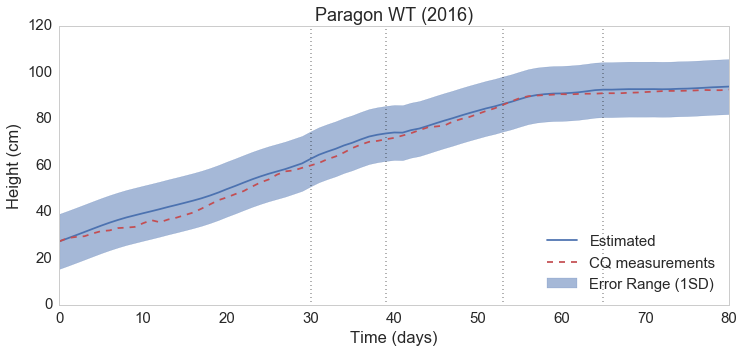

In [171]:
# Triggering warning message on CropQuant workstations
prev_st = 1
day = 0
rgr_2016_pred = []
plt.figure(figsize=(12, 5))

# Growth stage data in 2016
for idx, st in enumerate(pred_gs_2016):      
    day += 1
    if prev_st != int(st):
        day = 0
    
    curr_X = np.concatenate([X_2016[idx], [day]]).reshape(1, -1)
    #print int(st), day
    rgr_2016_pred.append(stage_models[int(st)].predict(curr_X)[0])
    prev_st = int(st)
    
y_2016_est = get_height_from_pred(27.3, rgr_2016_pred)
# Safe region with -/+ 1SD
upper_bound = y_2016_est + rh_std
lower_bound = y_2016_est - rh_std

grw_stgs_2016 = df_2016['Grow_Stg'].as_matrix()
for st in range(2, 7):
    st_pt = (grw_stgs_2016 == st).argmax()
    plt.plot([st_pt, st_pt], [-100, 1000], 'k:', alpha=0.34)

plt.plot(y_2016_est, label='Estimated', c=blue)
plt.plot(df_2016['Height'], '--', label='CQ measurements', c=red)

plt.fill_between(
    np.arange(y_2016_est.size), upper_bound, lower_bound, 
    alpha=0.5, interpolate=True, label="Error Range (1SD)",
    color=blue,
)
plt.xlim([0, y_2016_est.size - 1])
plt.ylim([0, 120])
    
plt.title("Paragon WT (2016)")
plt.xlabel("Time (days)")
plt.ylabel("Height (cm)")
plt.legend(loc="lower right")
plt.grid('off')

print "Paragon WT (2016)"
print "MSE: {:.3f}".format(mean_squared_error(df_2016['Height'], y_2016_est))
print "r (p): {:.3f} ({:.3f})".format(*pearsonr(df_2016['Height'], y_2016_est))

Paragon WT (2015)
MSE: 338.279
r (p): 0.992 (0.000)

Late DTEM (2015)
MSE: 685.075
r (p): 0.997 (0.000)

Early DTEM (2015)
MSE: 1564.520
r (p): 0.920 (0.000)

Stay Green (2015)
MSE: 11.422
r (p): 0.996 (0.000)

Short (2015)
MSE: 1028.006
r (p): 0.993 (0.000)

Overall Paragon Growth Data (2015)
MSE: 36.026
r (p): 0.999 (0.000)



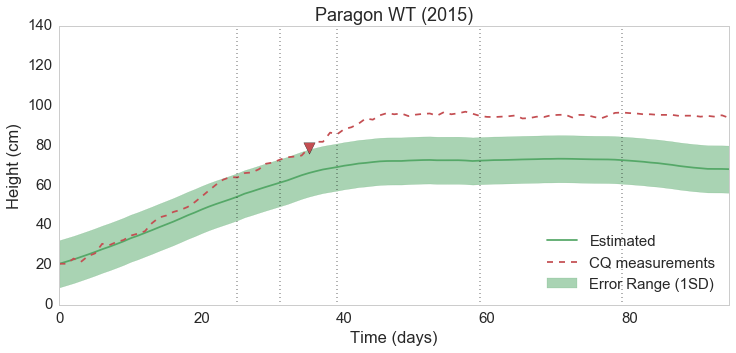

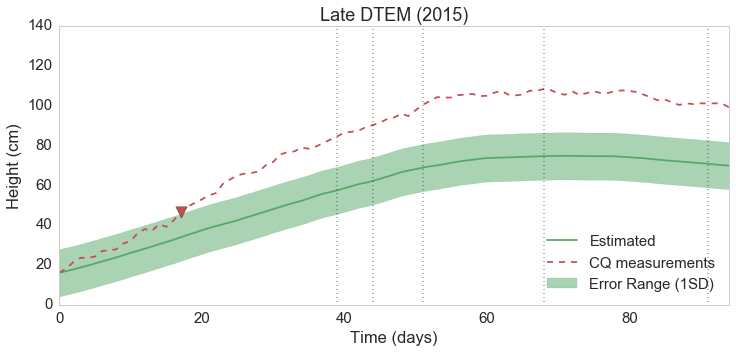

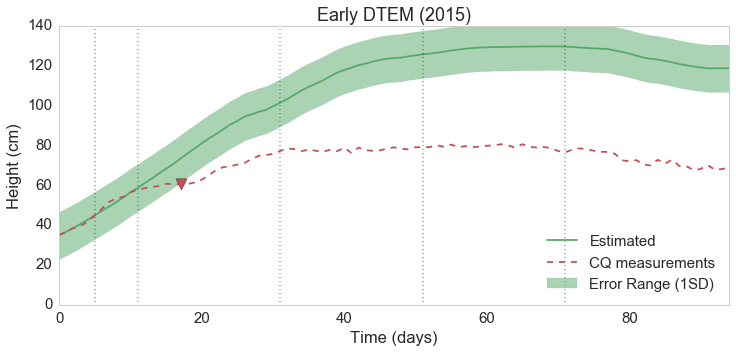

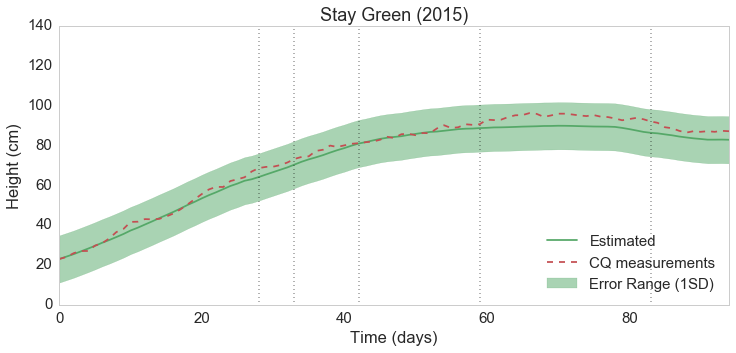

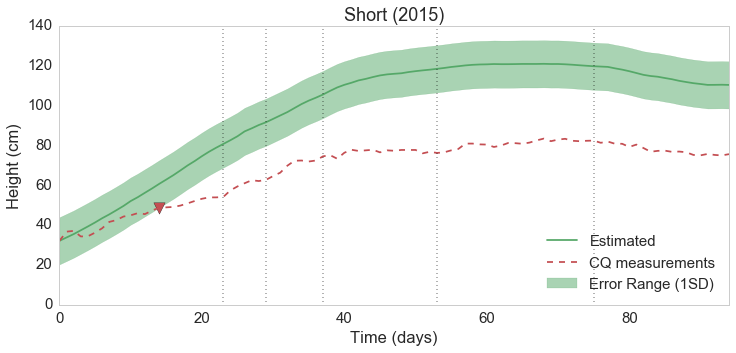

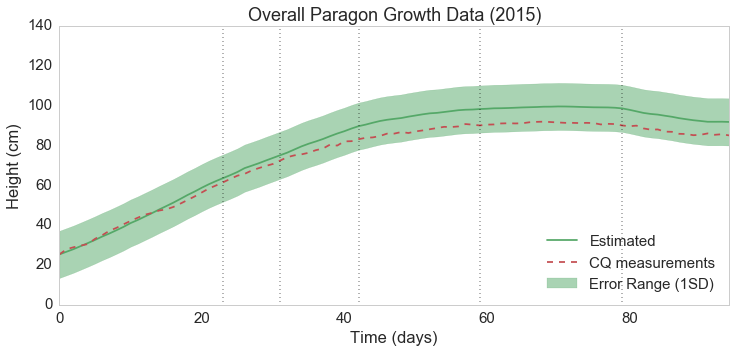

In [174]:
# Testing on each genotype in 2015
rgr_2015_preds = {}

for geno in genotypes:
    rgr_2015_preds[geno] = []

for ax_idx, geno in enumerate(genotypes):
    plt.figure(figsize=(12, 5))
    
    geno_mask = df_2015['Genotype'] == geno
    
    y_real_height = df_2015['Real_Height'][geno_mask].as_matrix()
    start = y_real_height[0]
    
    geno_stages = pred_gs_2015[np.delete(geno_mask.as_matrix(), na_to_drop)]   
    prev_st = 1
    day = 0
    rgr_2016_pred = []

    for idx, st in enumerate(geno_stages):
        day += 1
        if prev_st != int(st):
            day = 0

        curr_X = np.concatenate([X_2015[idx], [day]]).reshape(1, -1)
        rgr_2015_preds[geno].append(stage_models[int(st)].predict(curr_X)[0])

        prev_st = int(st)
    
    this_y_est = get_height_from_pred(start, rgr_2015_preds[geno])
    
    upper_bound = this_y_est + rh_std
    lower_bound = this_y_est - rh_std
    
    plt.title(geno_names[geno])
    plt.plot(this_y_est, label='Estimated', c=green)
    plt.fill_between(
        np.arange(this_y_est.size), upper_bound, lower_bound, 
        alpha=0.5, interpolate=True, label="Error Range (1SD)",
        color=green,
    )
    plt.plot(y_real_height, '--', label='CQ measurements', c=red)    
    
    grw_stgs_2015 = df_2015['Grow_Stg'][geno_mask].as_matrix()
    for st in range(2, 7):
        st_pt = (grw_stgs_2015 == st).argmax()
        plt.plot([st_pt, st_pt], [-100, 1000], 'k:', alpha=0.34)
        
    went_out, went_in = oob_values(y_real_height, lower_bound, upper_bound)
    
    # Only plot one point where the data leaves the bounds
    if went_out:
        went_out = [went_out[0]]
        plt.scatter(went_out, y_real_height[went_out], c=red, marker='v', s=128)
        #ax[idx].scatter(went_in, y_real_height[went_in], c='g', marker='^', s=64)        
    
    plt.xlim([0, this_y_est.size - 1])
    plt.ylim([0, 140])
    
    plt.xlabel("Time (days)")
    plt.ylabel("Height (cm)")
    plt.legend(loc="lower right")
    plt.grid('off')
    
    print geno_names[geno]
    print "MSE: {:.3f}".format(mean_squared_error(y_real_height, this_y_est))
    print "r (p): {:.3f} ({:.3f})".format(*pearsonr(y_real_height, this_y_est))
    print 


## Relative growth rate (RGR) stage modelling

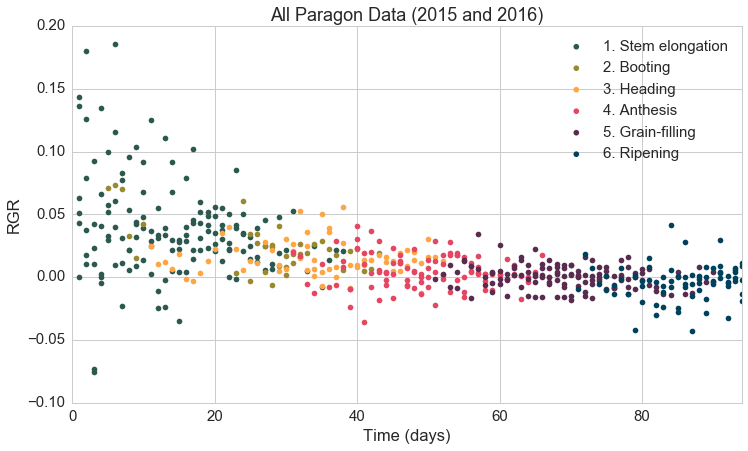

In [33]:
# Plot daily RGR
plt.figure(figsize=(12, 6.75))

y_2016_rgr = get_rgr(y_2016, 1)
y_2015_rgrs = {}

for geno in genotypes[:-1]:
    geno_mask = df_2015['Genotype'] == geno
    y_2015_rgrs[geno] = get_rgr(df_2015['Real_Height'][geno_mask].as_matrix(), 1)

cc = ColorConverter()
colours = [    
    cc.to_rgb('#2C594F'),
    cc.to_rgb('#998A2F'), 
    cc.to_rgb('#FFA644'),
    cc.to_rgb('#E54661'),
    cc.to_rgb('#592C4F'), 
    cc.to_rgb('#00415C'), 
]

labels = [
    '1. Stem elongation',
    '2. Booting',
    '3. Heading',
    '4. Anthesis',
    '5. Grain-filling',
    '6. Ripening'
]
    
for idx, st in enumerate(stages):
    st_2016_mask = (df_2016['Grow_Stg'] == st).as_matrix()[1:]
    curr_y = y_2016_rgr[st_2016_mask]
    curr_x = np.arange(y_2016_rgr.size)[st_2016_mask] + 1    
    plt.scatter(curr_x, curr_y, c=colours[idx], label=labels[idx], s=32, lw=0)
    
    for geno in genotypes[:-1]:        
        geno_mask = df_2015['Genotype'] == geno
        geno_stg_mask = (df_2015['Grow_Stg'][geno_mask] == st).as_matrix()[1:]
        curr_y = y_2015_rgrs[geno][geno_stg_mask]
        curr_x = np.arange(y_2015_rgrs[geno].size)[geno_stg_mask] + 1  
        plt.scatter(curr_x, curr_y, c=colours[idx], s=32, lw=0)
        
plt.xlim([0, 94])
plt.ylim([-0.1, 0.2])
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("RGR")
plt.title("All Paragon Data (2015 and 2016)")

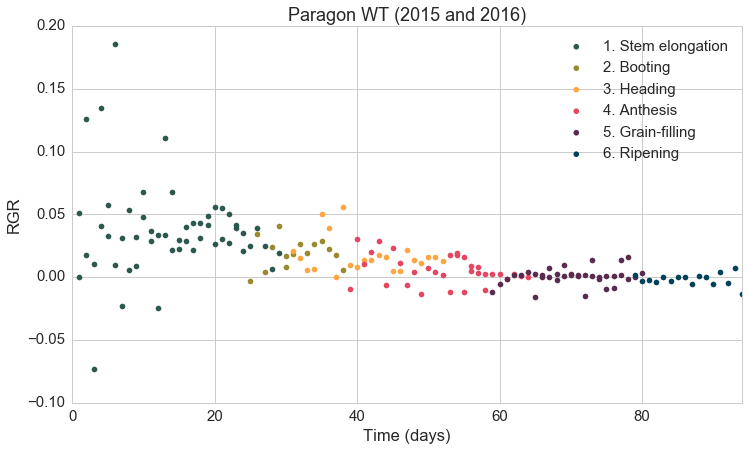

In [34]:
# Extract one line for testing
plt.figure(figsize=(12, 6.75))
    
for idx, st in enumerate(stages):
    st_2016_mask = (df_2016['Grow_Stg'] == st).as_matrix()[1:]
    curr_y = y_2016_rgr[st_2016_mask]
    curr_x = np.arange(y_2016_rgr.size)[st_2016_mask] + 1   
    plt.scatter(curr_x, curr_y, c=colours[idx], label=labels[idx], s=32, lw=0)

    geno = 'G1'
    geno_mask = df_2015['Genotype'] == geno
    geno_stg_mask = (df_2015['Grow_Stg'][geno_mask] == st).as_matrix()[1:]
    curr_y = y_2015_rgrs[geno][geno_stg_mask]
    curr_x = np.arange(y_2015_rgrs[geno].size)[geno_stg_mask] + 1
    plt.scatter(curr_x, curr_y, c=colours[idx], s=32, lw=0)
        
plt.xlim([0, 94])
plt.ylim([-0.1, 0.2])
plt.legend()
plt.xlabel("Time (days)")
plt.ylabel("RGR")
plt.title("Paragon WT (2015 and 2016)")

## FFT for growth pattern extraction 

In [35]:
def cycles_to_days(cyc):
    """ Convert a cycles-per-day value to the number of days the cycle occurs. """
    return 365.25 / (365.25 * cyc)

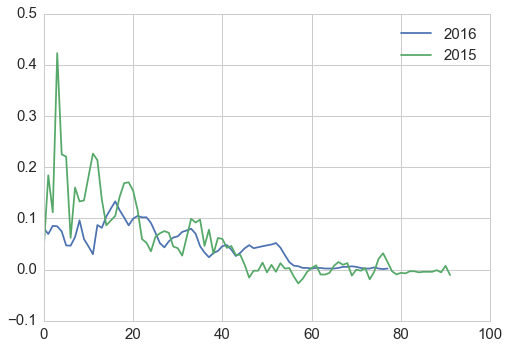

In [36]:
geno_mask = df_2015['Genotype'] == 'G1'
y_2016 = df_2016['Height'].as_matrix()
y_para_ctl = df_2015['Real_Height'][geno_mask].as_matrix()

y_2016_rgr = get_rgr(y_2016, 3)
y_para_ctl_rgr = get_rgr(y_para_ctl, 3)

plt.plot(y_2016_rgr, label='2016')
plt.plot(y_para_ctl_rgr, label='2015')
plt.legend()

(0, 0.8)

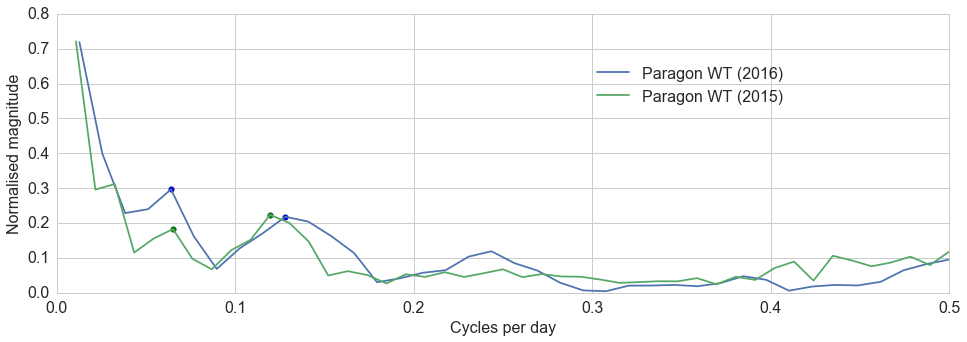

In [37]:
# FFT and peak detection  
fig = plt.figure(figsize=(16, 5))
y_2016_rgr = get_rgr(y_2016, 3)
y_para_ctl_rgr = get_rgr(y_para_ctl, 3)

y_2016_rgr = (y_2016_rgr ** 3.)[:90]
ft = np.fft.rfft(y_2016_rgr)
mgft = abs(ft)
mgft_norm_2016 = (mgft / mgft[0])[1:]
xVals_2016 = np.fft.rfftfreq(y_2016_rgr.size, d=1.0)

plt.plot(xVals_2016[1:y_2016_rgr.size], mgft_norm_2016, label="Paragon WT (2016)")
pts = [
    (0.064102564102564097, 0.29661814572323347),
    (0.12820512820512819, 0.21815138763825137),
]
offset = 0.01

for x, y in pts:
    plt.scatter(x, y, c='b', s=32)
    #print cycles_to_days(x)
    #plt.annotate("{:.2f} days".format(cycles_to_days(x)), (x+offset, y+offset), fontsize=16)

# Control line
ft = np.fft.rfft(y_para_ctl_rgr)
mgft = abs(ft)
mgft_norm_2015 = (mgft / mgft[0])[1:]
xVals_2015 = np.fft.rfftfreq(y_para_ctl_rgr.size, d=1.0)
plt.plot(xVals_2015[1:y_para_ctl_rgr.size], mgft_norm_2015, label="Paragon WT (2015)")
# generated through the pts calculation - presentation only
pts = [
    (0.065217391304347824, 0.18278695722358176),
    (0.11956521739130435, 0.22358253660900509),
]

for x, y in pts:
    plt.scatter(x, y, c='g', s=32)
    #print cycles_to_days(x)
    #plt.annotate("{:.2f} days".format(cycles_to_days(x)), (x+offset, y+offset), fontsize=16)

plt.legend(fontsize=16, bbox_to_anchor=(.83, .865))
plt.ylabel("Normalised magnitude", fontsize=16)
plt.xlabel("Cycles per day", fontsize=16)
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.xlim([0, 0.5])
plt.ylim([0, 0.8])
#zip(xVals_2015[1:y_para_ctl_rgr.size], mgft_norm_2015)
#zip(xVals_2016[1:y_2016_rgr.size], mgft_norm_2016)

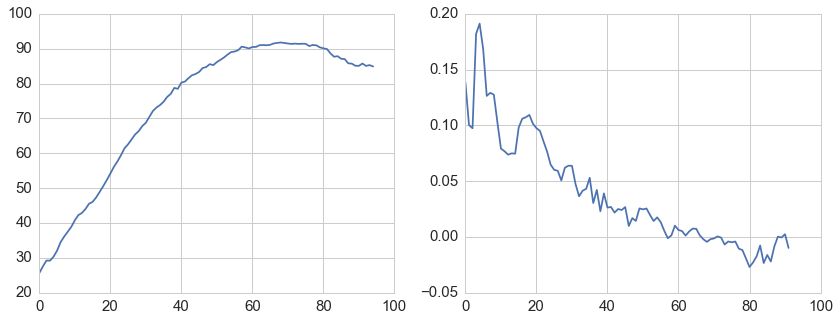

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

all_data_rh = np.nanmean(all_ys, 1) # Use all crop growth datasets
all_data_rgr = get_rgr(all_data_rh, 3)

ax[0].plot(all_data_rh)
ax[1].plot(all_data_rgr)

(46L,)


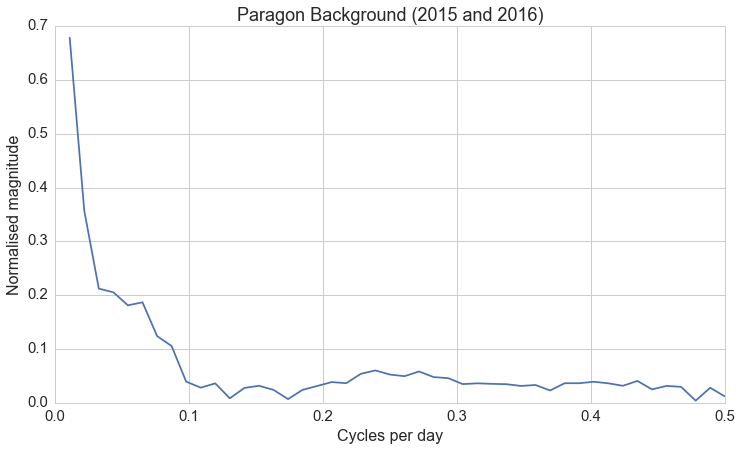

In [61]:
# Apply on RGR data instead of the real height data
plt.figure(figsize=(12, 6.75))

ft = np.fft.rfft(all_data_rgr)
mgft = abs(ft)
mgft_norm = (mgft / mgft[0])[1:]
xVals = np.fft.rfftfreq(all_data_rgr.size, d=1.0)

print mgft_norm.shape

plt.plot(xVals[1:all_data_rgr.size], mgft_norm) #, label="Paragon WT (2015)")
plt.ylabel("Normalised magnitude", fontsize=16)
plt.xlabel("Cycles per day", fontsize=16)
plt.title("Paragon Background (2015 and 2016)")

In [ ]:
###################################################################
#     END of the growth pattern and prediction modelling          #
###################################################################